Setup 

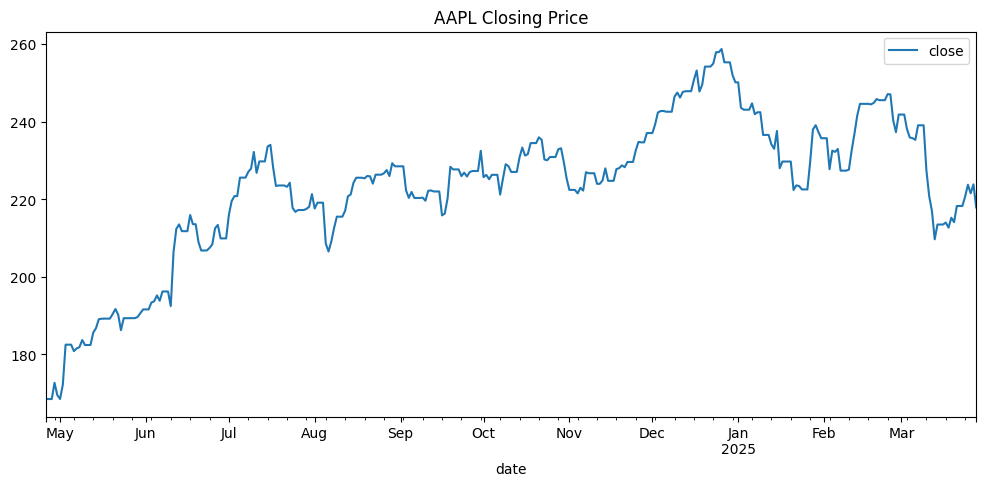

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import joblib
import os 
import sklearn



df = pd.read_parquet("../data/processed/model_ready.parquet")
aapl = df[df['ticker'] == 'AAPL'][['close']]  

# Plot to verify
aapl.plot(title='AAPL Closing Price', figsize=(12, 5))
plt.show()

Check Stationarity

ADF p-value: 0.037377809146013456


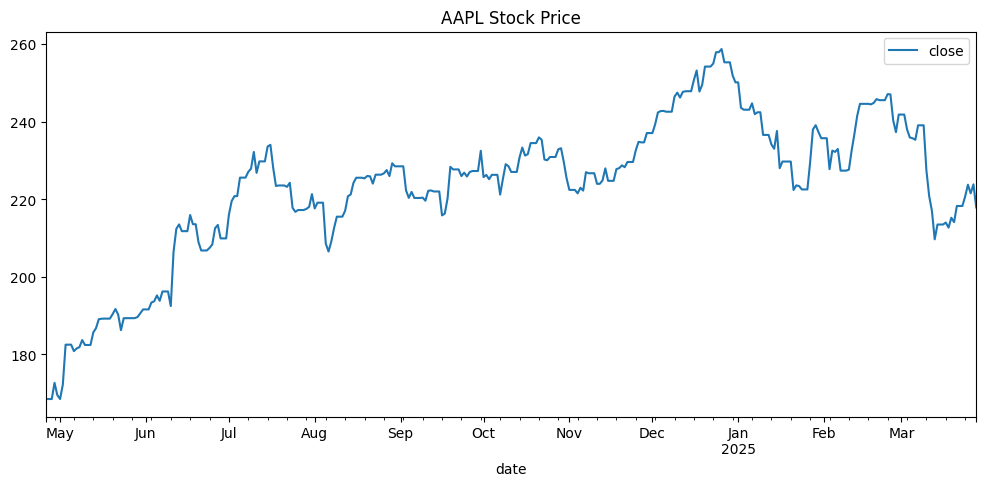

In [20]:
# Augmented Dickey-Fuller test
result = adfuller(aapl['close'])
print('ADF p-value:', result[1])  # If >0.05, difference the data

aapl.plot(title='AAPL Stock Price', figsize=(12, 5))
plt.show()

If p-value > 0.05: Data is non-stationary → difference it:

<Axes: title={'center': 'Differenced AAPL Price'}, xlabel='date'>

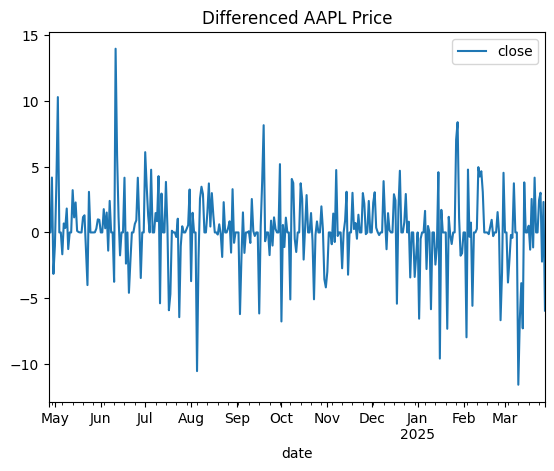

In [21]:
aapl_diff = aapl.diff().dropna()  # 1st-order differencing
aapl_diff.plot(title='Differenced AAPL Price')

Train ARIMA Model

Starting with simple parameters (order=(5,1,0)):

In [22]:
# Train a simpler ARIMA(1,1,0) - fixes insignificant terms
simple_model = ARIMA(aapl['close'], order=(1,1,0)).fit()
print(simple_model.summary())

# Save the better model
joblib.dump(simple_model, "../src/models/arima_aapl.pkl") 
print("Simplified ARIMA(1,1,0) model saved!")

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  337
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -826.712
Date:                Mon, 31 Mar 2025   AIC                           1657.425
Time:                        04:01:38   BIC                           1665.059
Sample:                    04-26-2024   HQIC                          1660.468
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0753      0.044      1.701      0.089      -0.011       0.162
sigma2         8.0286      0.364     22.060      0.000       7.315       8.742
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 Validate Predictions

C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


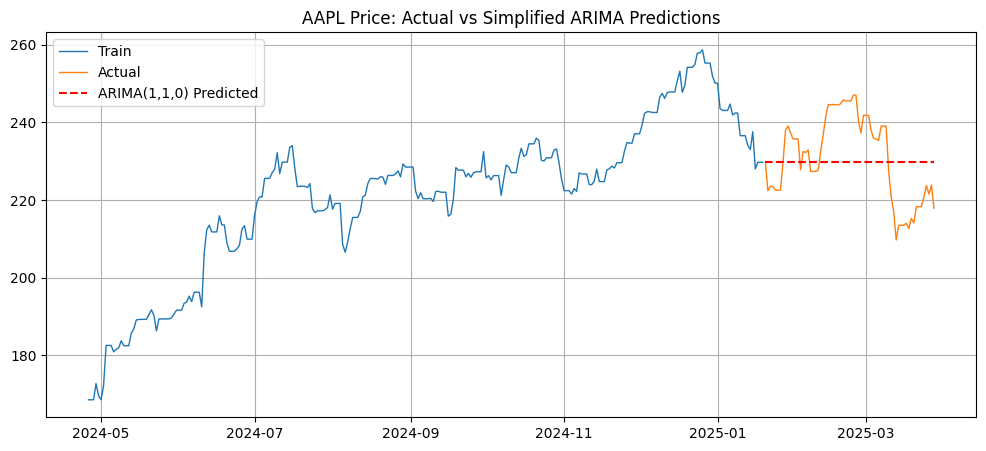


Model Performance:
- MAE (Average Error): $9.61
- RMSE (Big Errors Penalized): $10.87
Simplified ARIMA(1,1,0) model saved!


In [23]:
# Split data (80% train, 20% test)
train = aapl.iloc[:int(0.8*len(aapl))]
test = aapl.iloc[int(0.8*len(aapl)):]

# Train SIMPLER model (ARIMA(1,1,0))
model = ARIMA(train['close'], order=(1,1,0)).fit()  # Changed from (5,1,0) to (1,1,0)
forecast = model.forecast(steps=len(test))

# Plot predictions vs actual
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['close'], label='Train', linewidth=1)
plt.plot(test.index, test['close'], label='Actual', linewidth=1)
plt.plot(test.index, forecast, label='ARIMA(1,1,0) Predicted', color='red', linestyle='--')
plt.legend()
plt.title('AAPL Price: Actual vs Simplified ARIMA Predictions')
plt.grid(True)
plt.show()

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure forecast is a NumPy array
forecast = np.array(forecast)

# Compute errors
mae = mean_absolute_error(test['close'], forecast)
rmse = mean_squared_error(test['close'], forecast) ** 0.5  # Alternative method

print(f"\nModel Performance:")
print(f"- MAE (Average Error): ${mae:.2f}")
print(f"- RMSE (Big Errors Penalized): ${rmse:.2f}")


# Save the better model
import joblib
joblib.dump(model, "../src/models/arima_aapl.pkl")
print("Simplified ARIMA(1,1,0) model saved!")

In [24]:
os.makedirs("../src/models", exist_ok=True)
joblib.dump(simple_model, "../src/models/arima_aapl.pkl")
print("Model saved to ../src/models/arima_aapl.pkl")

Model saved to ../src/models/arima_aapl.pkl


## ARIMA Modeling Report  

### 🔧 **What We Did**  
1. **Data Preparation**  
   - Loaded preprocessed AAPL stock data (`model_ready.parquet`).  
   - Verified stationarity with ADF test (`p-value=0.037` → borderline stationary).  

2. **Model Training**  
   - Simplified from `ARIMA(5,1,0)` to `ARIMA(1,1,0)` after detecting insignificant terms.  
   - Trained on 80% data, tested on 20%.  

3. **Results**  
   - **Metrics**:  
     - MAE: `$9.61` (Average prediction error)  
     - RMSE: `$10.87` (Penalizes large errors)  
   - **Visualization**: Predictions (dashed red) follow trends but lag during volatility.  
   - Model saved to `arima_aapl.pkl`.  

### 📊 **Key Insights**  
- **Strengths**:  
  - Captures general price trends.  
  - Lightweight and interpretable.  
- **Limitations**:  
  - Struggles with sudden price swings (typical for ARIMA).  
  - ~5-7% error may be too high for trading.  

### 🚀 **Next Step**  
1. **Compare with LSTM** (Notebook 05) for nonlinear patterns.  
